In [4]:
import copy
import os
from typing import Optional, Tuple

import gym
import numpy as np
from gym.core import ObsType

import torch

# from augment.dim_reduction.autoencoders import VAE
# from augment.rl.algs.td3 import TD3


ENVS_DIR = '.'


class MyEnv(gym.Env):
    def __init__(self, rbf_n, d_fourier=None, neural=False):

        self.rbf_n = rbf_n
        self.d_fourier = d_fourier
        self.neural_features = None
        if self.d_fourier:
            print(d_fourier)
            self.d_fourier, self.sigma = d_fourier
            self.original_obs_dim = self.observation_space.shape[-1]
            self.observation_space = gym.spaces.Box(low=-1, high=+1, shape=(self.d_fourier+self.original_obs_dim,))

            load_dir = f'{ENVS_DIR}/fourier_basis/obs_dim_{self.original_obs_dim}/d_fourier_{self.d_fourier}/sigma_{self.sigma}'
            self.B = np.load(f'{load_dir}/B.npy')

        elif self.rbf_n:
            self.original_obs_dim = self.observation_space.shape[-1]
            self.observation_space = gym.spaces.Box(low=-1, high=+1, shape=(2*self.rbf_n,))

            load_dir = f'{ENVS_DIR}/rbf_basis/obs_dim_{self.original_obs_dim}/n_{rbf_n}/'
            self.P = np.load(f'{load_dir}/P.npy')
            self.phi = np.load(f'{load_dir}/phi.npy')
            self.nu = np.load(f'{load_dir}/nu.npy')

            print(self.nu)

            self.obs = None
            
    def _get_obs(self):
        if self.d_fourier:
            x = self.obs
            Bx = self.B.dot(x)
            fourier_obs = np.concatenate([np.sin(2*np.pi*Bx), np.cos(2*np.pi*Bx), x])
            return fourier_obs
        elif self.rbf_n:
            return self._rbf(self.obs)
        elif self.neural_features:
            obs = torch.from_numpy(self.obs).float()
            features = self.neural_features(obs)
            # print(features.detach().numpy())
            return features.detach().numpy()
        else:
            return self.obs

    def _rbf(self, obs):
        sin = np.sin(self.P.dot(obs)/np.sqrt(self.rbf_n) + self.phi)
        cos = np.cos(self.P.dot(obs)/np.sqrt(self.rbf_n) + self.phi)
        return np.concatenate((sin, cos))

    def _rbf_inverse(self, rbf_obs):
        return np.atanh(self.P.dot(rbf_obs)/self.nu + self.phi)


class Goal2DEnv(MyEnv):
    def __init__(self, delta=0.025, sparse=1, rbf_n=None, d_fourier=None, neural=False, d=1, quadrant=False, center=False):

        self.n = 2
        self.action_space = gym.spaces.Box(low=np.zeros(2), high=np.array([1, 2 * np.pi]), shape=(self.n,))

        self.boundary = 1.05
        self.observation_space = gym.spaces.Box(-self.boundary, +self.boundary, shape=(2 * self.n,), dtype="float64")

        self.step_num = 0
        self.delta = delta

        self.sparse = sparse
        self.d = d
        self.x_norm = None
        self.quadrant = quadrant
        self.center = center
        super().__init__(rbf_n=rbf_n, d_fourier=d_fourier, neural=neural)

    def _clip_position(self):
        # Note: clipping makes dynamics nonlinear
        self.x = np.clip(self.x, -self.boundary, +self.boundary)

    def step(self, a):

        self.step_num += 1
        ux = a[0] * np.cos(a[1])
        uy = a[0] * np.sin(a[1])
        u = np.array([ux, uy])

        self.x += u * self.delta
        self._clip_position()

        dist = np.linalg.norm(self.x - self.goal)
        terminated = dist < 0.05
        truncated = False

        if self.sparse:
            reward = +1.0 if terminated else -0.1
        else:
            reward = -dist

        info = {}
        self.obs = np.concatenate((self.x, self.goal))
        return self._get_obs(), reward, terminated, truncated, info

    def _sample_goal(self):
        goal = np.random.uniform(low=-self.d, high=self.d, size=(self.n,))
        if self.quadrant:
            goal = np.random.uniform(low=0, high=1, size=(self.n,))
        return goal

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[ObsType, dict]:

        self.step_num = 0

        self.x = np.random.uniform(-1, 1, size=(self.n,))
        self.goal = self._sample_goal()

        dist = np.linalg.norm(self.x - self.goal)
        while dist < 0.05:
            self.goal =self._sample_goal()
            dist = np.linalg.norm(self.x - self.goal)

        self.obs = np.concatenate((self.x, self.goal))
        return self._get_obs(), {}

    def set_state(self, pos, goal):
        self.x = pos
        self.goal = goal


class Goal2DQuadrantEnv(Goal2DEnv):
    def __init__(self, d=1, rbf_n=None, d_fourier=None, neural=False):
        super().__init__(delta=0.025, sparse=1, rbf_n=rbf_n, d_fourier=d_fourier, neural=neural, d=d, quadrant=True)

In [5]:
env = Goal2DEnv()

/home/abenechehab/miniconda3/envs/cleanrl/lib/python3.9/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [6]:
env.reset()

(array([-0.11326975,  0.48898916,  0.36800032,  0.97966751]), {})

In [18]:
env.observation_space

Box(-1.05, 1.05, (4,), float64)

In [8]:
env.action_space

Box(0.0, [1.        6.2831855], (2,), float32)

In [11]:
env.step(np.array([0.5,0.5]))

(array([-0.10229997,  0.49498198,  0.36800032,  0.97966751]),
 -0.1,
 False,
 False,
 {})

In [15]:
env.goal

array([0.36800032, 0.97966751])

In [16]:
import matplotlib.pyplot as plt

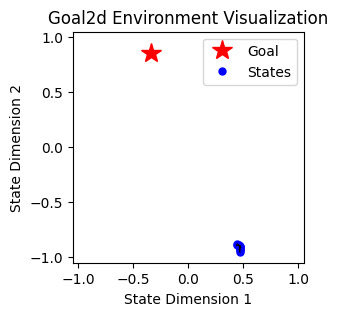

In [22]:
# Reset the environment to get the initial state
state, _ = env.reset()

# Get the observation space limits
obs_space = env.observation_space
obs_low = obs_space.low
obs_high = obs_space.high

# Get the goal
goal = env.goal

# Initialize lists to store the states and actions
states = [state]
actions = []

# Simulate the agent taking random actions
num_steps = 10  # Number of steps to simulate
for _ in range(num_steps):
    action = env.action_space.sample()
    actions.append(action)
    next_state, reward, terminated, truncated, _ = env.step(action)
    states.append(next_state)
    if terminated or truncated:
        break

# Convert states to a numpy array for easier plotting
states = np.array(states)

# Plot the state space and the goal
plt.figure(figsize=(3, 3))
plt.xlim(obs_low[0], obs_high[0])
plt.ylim(obs_low[1], obs_high[1])
plt.gca().set_aspect('equal', adjustable='box')

# Plot the goal as a star
plt.plot(goal[0], goal[1], '*', markersize=15, color='red', label='Goal')

# Plot the states as small dots
plt.plot(states[:, 0], states[:, 1], 'o', markersize=5, color='blue', label='States')

# Plot segments linking the states
for i in range(len(states) - 1):
    plt.plot([states[i, 0], states[i + 1, 0]], [states[i, 1], states[i + 1, 1]], 'k-', linewidth=1)

# Add labels and legend
plt.xlabel('State Dimension 1')
plt.ylabel('State Dimension 2')
plt.title('Goal2d Environment Visualization')
plt.legend()

# Show the plot
plt.show()


In [21]:
env.action_space.sample()

array([0.6339286, 5.175787 ], dtype=float32)